In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import signatory
import base
import neural_inverse
from importlib import reload
import time as timing

## Learn the inverse of log-signature (pytorch)

In [21]:
reload(neural_inverse)
N = 20
batch = 10
order = 5
path = neural_inverse.generate_bmpath(batch, N)
start_time = timing.time()
y_recover, logsig_recover, net = neural_inverse.inverse_multiple_path(path, order)
end_time = timing.time()
print("Duration: {}".format(end_time - start_time))

In [2]:
reload(neural_inverse)
N = 20
samples = 100
order = 5
path = neural_inverse.generate_bmpath(samples, N)
time = np.linspace(0,1,N+1)
time_torch = np.tile(time[None,:,None],[64,1,1])
time_torch = torch.Tensor(time_torch)

path = np.array([np.concatenate([time[:,None],path0],axis = -1) for path0 in path])
logsig = signatory.logsignature(torch.tensor(path), order)
net, y_recover, logsig_recover = neural_inverse.inverse_multiple_path_time(logsig, N, order, time_torch, 1)

# start_time = timing.time()
# y_recover, logsig_recover, net = neural_inverse.inverse_multiple_path(path, order)
# end_time = timing.time()
# print("Duration: {}".format(end_time - start_time))

step:  0 loss:  0.12032012827694416
step:  100 loss:  0.000572538745473139


KeyboardInterrupt: 

NameError: name 'y_recover' is not defined

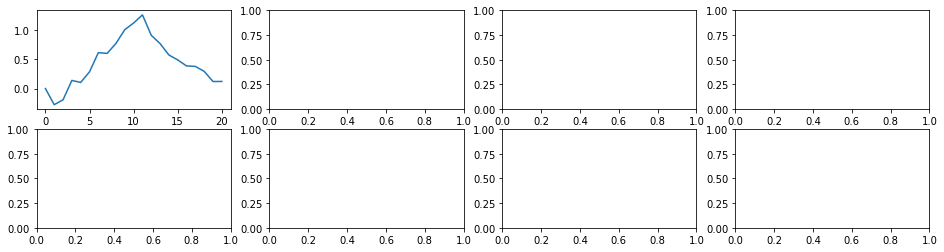

In [3]:
f,p=plt.subplots(2,4,figsize=(16,4)) 
for i in range(2):
    for j in range(4):
        idx = np.random.randint(0,100)
        p[i,j].plot(path[idx,:,-1], label = 'True')
        p[i,j].plot(y_recover[idx,:,-1], label = 'Recover')
        p[i,j].grid()
        p[i,j].legend()
plt.suptitle('Training set')
plt.show()

In [91]:
path_test = neural_inverse.generate_bmpath(samples, N)
path_test = np.exp(path_test - 0.5*time[None,:,None])

path_test = np.array([np.concatenate([time[:,None],path0],axis = -1) for path0 in path_test])
logsig_test = signatory.logsignature(torch.tensor(path_test), order)
with torch.no_grad():  
    X = torch.tensor(logsig_test, dtype = torch.float)
    y_predict_test, X_predict_test = net(X)    

<ipython-input-91-6aba86d12a0c>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(logsig_test, dtype = torch.float)


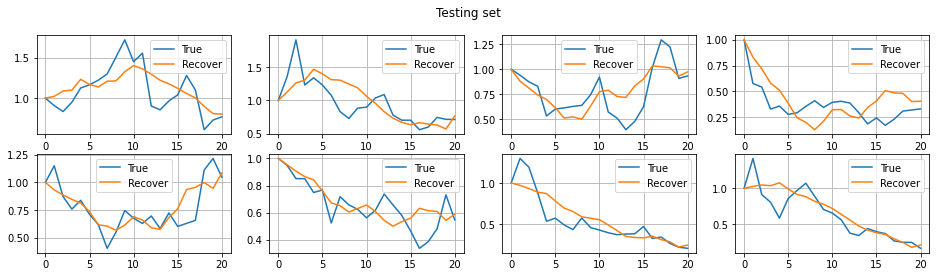

In [93]:
f,p=plt.subplots(2,4,figsize=(16,4)) 
for i in range(2):
    for j in range(4):
        idx = np.random.randint(0,640)
        p[i,j].plot(path_test[idx,:,-1], label = 'True')
        p[i,j].plot(y_predict_test[idx,:,-1] + path_test[idx,0,-1], label = 'Recover')
        p[i,j].grid()
        p[i,j].legend()
plt.suptitle('Testing set')
plt.show()

## Reverse a single path

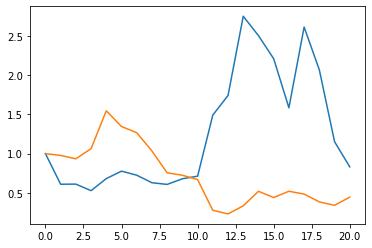

In [5]:
import time as timing
N = 20
sigma = 1
order = 5
time = np.linspace(0,1,N+1)

pathBM0 = neural_inverse.generate_bmpath(1, N)
path0 = np.exp(sigma * pathBM0 - 0.5*sigma**2*time[None,:,None])

pathBM1 = neural_inverse.generate_bmpath(1, N)
path1 = np.exp(sigma * pathBM1 - 0.5*sigma**2*time[None,:,None])

path_two = np.concatenate([path0,path1],axis = -1)

path_time_0 = np.concatenate([time[None,:,None],path0],axis = -1)

path_time = np.concatenate([time[None,:,None],path_two],axis = -1)

plt.plot(path_two[0])

### 2-d path (neural method)

In [6]:
reload(neural_inverse)
logsig_two = signatory.logsignature(torch.tensor(path_two), order)
net_two, y_recover_two, logsig_recover_two = neural_inverse.inverse_single_path_two(logsig_two, N, order)

step:  0 loss:  2.4002013206481934
step:  100 loss:  0.005096316337585449
step:  200 loss:  0.004996357951313257
step:  300 loss:  0.004946514964103699
step:  400 loss:  0.004906441085040569
step:  500 loss:  0.0048457058146595955
step:  600 loss:  0.004698405507951975
step:  700 loss:  0.0041214535012841225
step:  800 loss:  0.0027019469998776913
step:  900 loss:  0.00011766229727072641
Finished Training


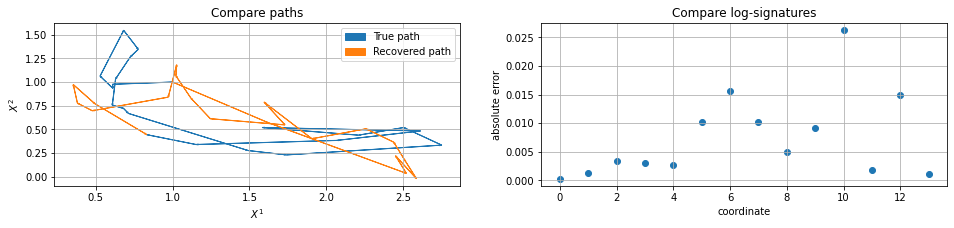

In [7]:
def plot_helper_2dpath(p,path_two,color):
    for i in range(N):
        x0 = path_two[0,i,0]
        y0 = path_two[0,i,1]
        x1 = path_two[0,i+1,0] - path_two[0,i,0]
        y1 = path_two[0,i+1,1] - path_two[0,i,1]
        l = p.arrow(x0, y0, x1, y1,length_includes_head=True, head_width=.01, color = color)
    return l
f,p=plt.subplots(1,2,figsize=(16,3)) 
l1 = plot_helper_2dpath(p[0], path_two,'tab:blue')
l2 = plot_helper_2dpath(p[0], y_recover_two + path_two[0,0,:],'tab:orange')
p[0].grid()
p[0].legend((l1, l2), ['True path', 'Recovered path'])
p[0].set_xlabel('$X^{1}$')
p[0].set_ylabel('$X^{2}$')
p[0].title.set_text('Compare paths')

p[1].scatter(np.arange(logsig_two.shape[-1]), torch.abs(logsig_two[0] - logsig_recover_two[0]))
p[1].set_xlabel('coordinate')
p[1].set_ylabel('absolute error')
p[1].title.set_text('Compare log-signatures')
p[1].grid()
# plt.setp(p[1], xticks=np.arange(logsig_two.shape[-1]), xticklabels=signatory.lyndon_words(2,5))
# print(logsig_recover_two)
# print(logsig_two)

### Time augmented

In [8]:
reload(neural_inverse)
logsig_time = signatory.logsignature(torch.tensor(path_time), order)
net_time, y_recover_time, logsig_recover_time = neural_inverse.inverse_single_path_time(logsig_time,\
                                                N, order, torch.Tensor(time)[None,:,None],2)

step:  0 loss:  0.40888190269470215
step:  100 loss:  0.0049525415524840355
step:  200 loss:  0.0011847951682284474
step:  300 loss:  0.00016174752090591937
step:  400 loss:  5.190162846702151e-05
step:  500 loss:  4.460989293875173e-05
step:  600 loss:  4.134183473070152e-05
step:  700 loss:  3.8419475458795205e-05
step:  800 loss:  3.572998321033083e-05
step:  900 loss:  3.3202530175913125e-05
Finished Training


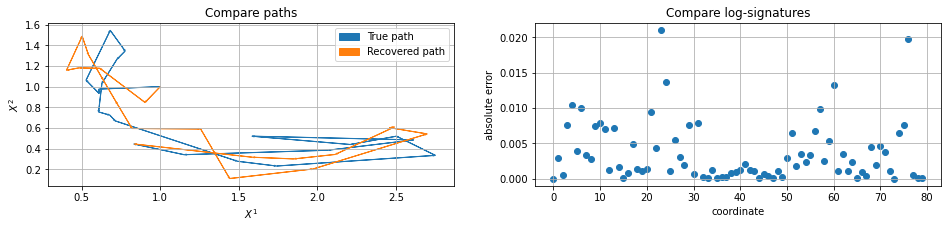

In [10]:
f,p=plt.subplots(1,2,figsize=(16,3)) 
l1 = plot_helper_2dpath(p[0], path_time[:,:,1:],'tab:blue')
l2 = plot_helper_2dpath(p[0], y_recover_time[:,:,1:] + path_time[0,0,1:],'tab:orange')
p[0].grid()
p[0].legend((l1, l2), ['True path', 'Recovered path'])
p[0].set_xlabel('$X^{1}$')
p[0].set_ylabel('$X^{2}$')
p[0].title.set_text('Compare paths')

p[1].scatter(np.arange(logsig_time.shape[-1]), torch.abs(logsig_time[0] - logsig_recover_time[0]))
p[1].set_xlabel('coordinate')
p[1].set_ylabel('absolute error')
p[1].title.set_text('Compare log-signatures')
p[1].grid()

### Compare

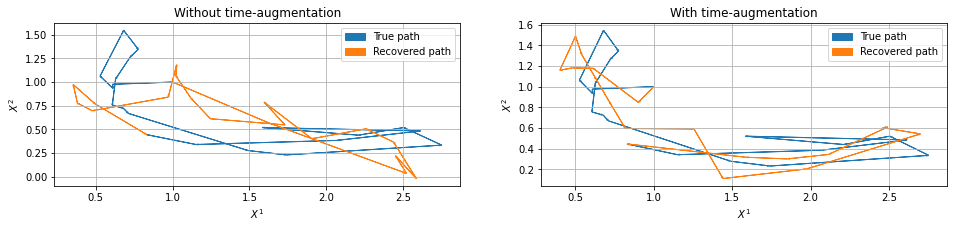

In [11]:
f,p=plt.subplots(1,2,figsize=(16,3)) 

l1 = plot_helper_2dpath(p[0], path_two,'tab:blue')
l2 = plot_helper_2dpath(p[0], y_recover_two + path_two[0,0,:],'tab:orange')
p[0].grid()
p[0].legend((l1, l2), ['True path', 'Recovered path'])
p[0].set_xlabel('$X^{1}$')
p[0].set_ylabel('$X^{2}$')
p[0].title.set_text('Without time-augmentation')

l1 = plot_helper_2dpath(p[1], path_time[:,:,1:],'tab:blue')
l2 = plot_helper_2dpath(p[1], y_recover_time[:,:,1:] + path_time[0,0,1:],'tab:orange')
p[1].grid()
p[1].legend((l1, l2), ['True path', 'Recovered path'])
p[1].set_xlabel('$X^{1}$')
p[1].set_ylabel('$X^{2}$')
p[1].title.set_text('With time-augmentation')

# plt.setp(p[1], xticks=np.arange(logsig_two.shape[-1]), xticklabels=signatory.lyndon_words(2,5))
# print(logsig_recover_time)
# print(logsig_time)

### 1-d path (neural method)

In [28]:
# plt.plot(path0[0,:,0])
# plt.show()
reload(neural_inverse)
logsig0 = signatory.logsignature(neural_inverse.leadlag(torch.tensor(path0)[:,:,0]), order)

start_time = timing.time()
net0, y_recover0, logsig_recover0 = neural_inverse.inverse_single_path(path0, order)
end_time = timing.time()
print("Duration: {}".format(end_time - start_time))

(1, 14)
(1, 41, 2)
step:  0 loss:  10.145337104797363
step:  100 loss:  0.013835201971232891
step:  200 loss:  0.005416812840849161
step:  300 loss:  0.0033370177261531353
step:  400 loss:  0.0021182599011808634


KeyboardInterrupt: 

In [13]:
reload(neural_inverse)
logsig_time_0 = signatory.logsignature(torch.tensor(path_time_0), order)
net_time, y_recover_time_0, logsig_recover_time_0 = neural_inverse.inverse_single_path_time(logsig_time_0, N,\
                                                    order, torch.Tensor(time)[None,:,None], 1)
y_recover_time_0 = y_recover_time_0[0,:,1] + path_time_0[0,0,1]

step:  0 loss:  0.4663487374782562
step:  100 loss:  0.007354173343628645
step:  200 loss:  0.001666760304942727
step:  300 loss:  0.00019979782518930733
step:  400 loss:  0.00019192617037333548
step:  500 loss:  0.00017248348740395159
step:  600 loss:  0.00015303691907320172
step:  700 loss:  0.00013511505676433444
step:  800 loss:  0.00012126695219194517
step:  900 loss:  0.00010966273111989722
Finished Training


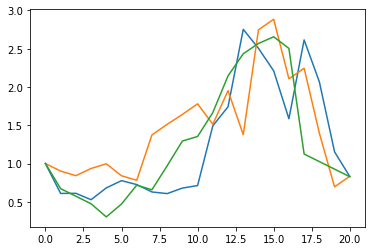

In [14]:
plt.plot(path0[0])
plt.plot(y_recover0)
plt.plot(y_recover_time_0)

## Compare with evolution algorithm
comparison is conducted on two aspects
1. recovered path 
2. hedging performance with the recovered path

In [315]:
import base
import logsig_inversion
reload(logsig_inversion)
pip = 0.01
n_pips = 10
n_points = N+1
order = 5
n_iterations = 100
n_organisms = 1000

start_time = timing.time()
y_recover1, loss = logsig_inversion.train(logsig0.numpy()[0], order, n_iterations, n_organisms, n_points, pip, n_pips)
y_recover1 = y_recover1 + path0[0,0,0]
end_time = timing.time()
print("Duration: {}".format(end_time - start_time))


Duration: 100.24750971794128


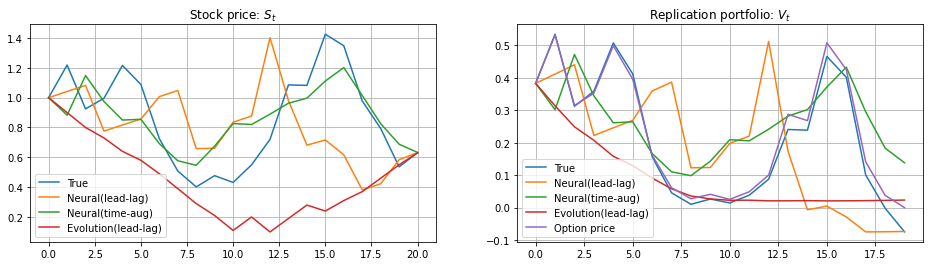

True log signature: 
 tensor([-0.3685, -0.3685, -0.4741, -0.0769,  0.0697, -0.0160,  0.0286, -0.0163,
        -0.0015,  0.0038, -0.0156, -0.0040,  0.0033,  0.0016])
Neural log signature: 
 tensor([-0.3685, -0.3685, -0.4741, -0.0773,  0.0699, -0.0154,  0.0271, -0.0180,
        -0.0015,  0.0035, -0.0138, -0.0037,  0.0045,  0.0019])
Evolution log signature: 
 tensor([-0.3700, -0.3700, -0.0741,  0.0276, -0.0282, -0.0072,  0.0144, -0.0073,
         0.0013, -0.0039,  0.0091,  0.0039, -0.0090, -0.0013],
       dtype=torch.float64)


<ipython-input-319-f09d85ffb294>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XX = torch.tensor(logsig0, dtype = torch.float32)


In [319]:
import hedge
reload(hedge)
K = 1
V_recover0, V_recover1 = hedge.delta_comapre(K,sigma,time,path0,y_recover0,y_recover1, y_recover_time_0)

logsig_recover1 = signatory.logsignature(neural_inverse.leadlag(torch.tensor(y_recover1)[None,:]), order)

XX = torch.tensor(logsig0, dtype = torch.float32)
print('True log signature: \n', XX[0])
print('Neural log signature: \n', logsig_recover0[0])
print('Evolution log signature: \n', logsig_recover1[0])